# Simulating Noisy InSAR Satellite Data 

# 0. Preface and Libraries

This notebook outlines the code used to mathematically model InSAR satellite data containing 3 types of noise: random, tropospheric, and topographic. Furthermore, it mentions steps taken to make calculations more efficient in the case of generating extremely large datasets.

Becuase this data is used to train a Noise2Noise model the only requirement for each noise is that the expected value of the noise must equal 0.

Only if parameter choices were not given in supplemental powerpoint materials will the reason be expliclity stated.

In [4]:
import numpy as np
from scipy.ndimage import gaussian_filter
import random
import matplotlib.pyplot as plt

# Here we can define the size of each data point we want to generate.
size = (1500, 1500)

## 1. Simulating Random Noise using Gaussian Distribtuion. 

The first and most trivial type of noise we need to add is the random noise. 

We are simulating this as a Gaussian (normal) distribution with $\mu = 0$ and $\sigma = 0.56$. 

In [5]:
def generate_random_noise(size, std=0.56):
    # Return a matrix with a normal distribution with mean at 0 
    return np.random.normal(loc=0.0, scale=std, size=size)

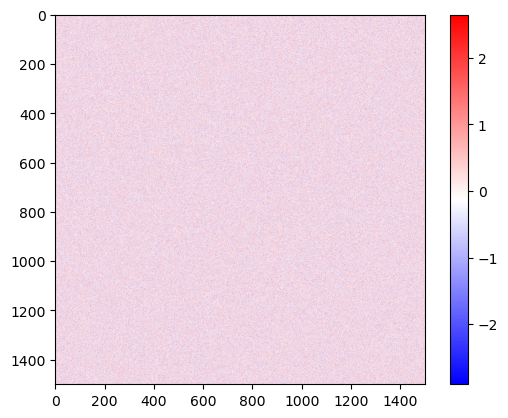

In [6]:
test_gaus = generate_random_noise(size)
plt.imshow(test_gaus, cmap='bwr')
plt.colorbar()

## 2. Simulating Tropospheric Noise

The second type of noise we are simulating is tropospheric noise. 

This noise is slightly different than our Gaussian noise as it's not "White Noise." That is to say, each pixel is not independent in picking from the distribution. Rather, the frequency across the x and y axes determines the noise level at a specific pixel. 

First, we can calculate the radial frequency (circular frequency from the center) by calculating the magnitude as $k = \sqrt{k_{x}^{2} + k_{y}^{2}}$

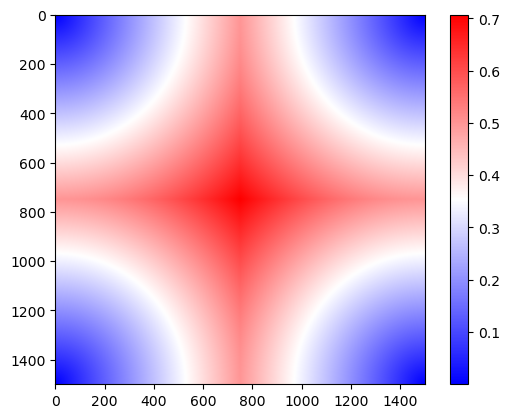

In [ ]:
beta=1.82

# Create our discrte frequency distributions over x and y axes
ky = np.fft.fftfreq(size[0])
kx = np.fft.fftfreq(size[1])

# Mesh them together get the specific axes
kx, ky = np.meshgrid(kx, ky)

# Compute the radial spatial frequency (frequency from the center)
k = np.sqrt(kx**2 + ky**2)
k[0, 0] = 1e-7

test_gaus = generate_random_noise(size)
plt.imshow(k, cmap='bwr')
plt.colorbar()

After that, we can create a standard normal distribution (but using fourier transform so we can calculate alongside our radial frequency).

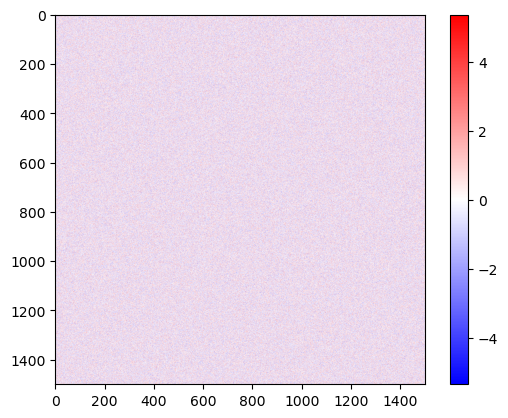

In [16]:
# Create a frequency domain based on a standard normal distribution
noise = np.fft.fft2(np.random.randn(*size)) 
plt.imshow(np.fft.ifft2(noise).real, cmap='bwr')
plt.colorbar()

Finally we can use the radial frequency to calculate a power matrix and use an inverse fourier transform to create our tropospheric noise.

[[5.49540874e+12 6.03234389e+05 1.70848630e+05 ... 8.16818204e+04
  1.70848630e+05 6.03234389e+05]
 [6.03234389e+05 3.21032348e+05 1.39451563e+05 ... 7.42140430e+04
  1.39451563e+05 3.21032348e+05]
 [1.70848630e+05 1.39451563e+05 9.09230935e+04 ... 5.84517665e+04
  9.09230935e+04 1.39451563e+05]
 ...
 [8.16818204e+04 7.42140430e+04 5.84517665e+04 ... 4.34698470e+04
  5.84517665e+04 7.42140430e+04]
 [1.70848630e+05 1.39451563e+05 9.09230935e+04 ... 5.84517665e+04
  9.09230935e+04 1.39451563e+05]
 [6.03234389e+05 3.21032348e+05 1.39451563e+05 ... 7.42140430e+04
  1.39451563e+05 3.21032348e+05]]


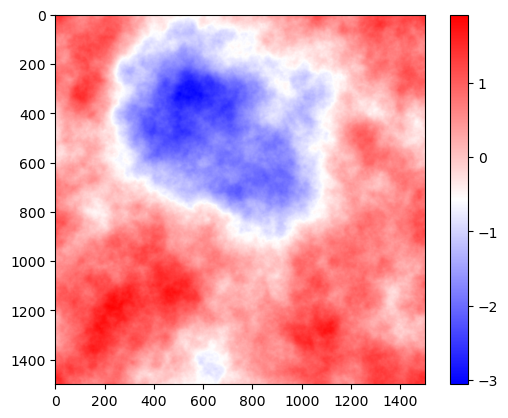

In [ ]:
# Calculate the power law
power = k ** (-beta)
# Use inverse fourier transform to calculate it back in spatial domain
frac_noise = np.fft.ifft2(noise * power).real
# Normalize it
frac_noise = (frac_noise - frac_noise.mean()) / frac_noise.std()
plt.imshow(frac_noise, cmap='bwr')
plt.colorbar()

To make the calculation more efficient, we can remove the generation of k and the power matrix as they are constant for a given size. The only random aspect comes from the noise generated.

Therefore if we are creating 1000 images all of the same size, the power array will be precomputed.

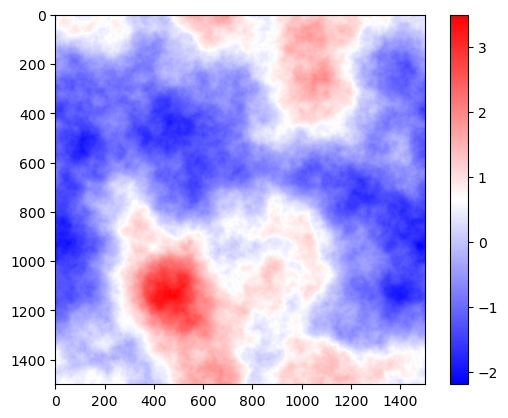

In [21]:
beta=1.82

# Create our discrte frequency distributions over x and y axes
ky = np.fft.fftfreq(size[0])
kx = np.fft.fftfreq(size[1])

# Mesh them together get the specific axes
kx, ky = np.meshgrid(kx, ky)

# Compute the radial spatial frequency (frequency from the center)
k = np.sqrt(kx**2 + ky**2)
k[0, 0] = 1e-7

# Calculate the power law
power_array = k ** (-beta)

def generate_tropospheric_noise():
    noise = np.fft.fft2(np.random.randn(*size))
    frac_noise = np.fft.ifft2(noise * power_array).real
    std_val = frac_noise.std()
    if std_val > 1e-9:
        frac_noise = (frac_noise - frac_noise.mean()) / std_val
    else:
        frac_noise = frac_noise - frac_noise.mean()
    return frac_noise

plt.imshow(generate_tropospheric_noise(), cmap='bwr')
plt.colorbar()

# 4. Simulating Subsidence Signal

In addition to the noisy data, we need to simulate the "background" of the image itself. Using the synthetic subsidence "Zoback model" outlined in the paper we mathematically calculate what we are aiming to recover with our CNN models.

$u_{r}(r, 0) = -\frac{1}{\pi c_m (1 - v)} \frac{r}{(r^2 + D^2)^\frac{3}{2}} \Delta P_p V$

$u_{z}(r, 0) = -\frac{1}{\pi c_m (1 - v)} \frac{D}{(r^2 + D^2)^\frac{3}{2}} \Delta P_p V$

A few parameters not listed in this formula are the azimuth angle, incidence angle, and time. We want the calculate this as the change of $\Delta P_p$ over time. 

Furthermore, to properly project the 3d change onto a 2d space, we need to know the incidence and azimuth angles of the satellite. For now we can assume an ascending satellite although in the class custom angle combinations can be set.

In [ ]:
# Parameters for the subsidence signal calculation
D=50, 
nu=0.25, 
cm=1.0, 
V=1.0, 

# Assume ascending satellite with the following parameters
incidence_angle_deg=40, 
satellite_azimuth_deg=15

# Calculate the radius and center of the image
y, x = np.indices(size)
cx, cy = size[1] // 2, size[0] // 2
r_sq = (x - cx)**2 + (y - cy)**2
r = np.sqrt(r_sq)
azimuth = np.arctan2(y - cy, x - cx)

In [ ]:
self.r, self.subsidence_denominator, self.azimuth = Noise2NoiseDataset._generate_subsidence_constants(size, D)

@staticmethod
def _generate_subsidence_constants(size, D):
    y, x = np.indices(size)
    cx, cy = size[1] // 2, size[0] // 2
    r_sq = (x - cx)**2 + (y - cy)**2
    r = np.sqrt(r_sq)
    denominator_base = r**2 + D**2
    denominator_base[denominator_base < 1e-9] = 1e-9
    azimuth = np.arctan2(y - cy, x - cx)
    return r, denominator_base, azimuth

@staticmethod
def _calculate_los_vector(incidence_angle_deg, satellite_azimuth_deg):
    incidence_angle_rad = np.deg2rad(incidence_angle_deg)
    satellite_azimuth_rad = np.deg2rad(satellite_azimuth_deg)
    look_azimuth_rad = satellite_azimuth_rad + np.pi/2
    l_east = np.sin(incidence_angle_rad) * np.sin(look_azimuth_rad)
    l_north = np.sin(incidence_angle_rad) * np.cos(look_azimuth_rad)
    l_up = np.cos(incidence_angle_rad)
    return np.array([l_east, l_north, l_up])


In [ ]:
def generate_subsidence(self, delta_P):
    factor = (-1 / np.pi) * self.cm * (1 - self.nu) * delta_P * self.V
    uz = factor * (self.D / (self.subsidence_denominator**1.5))
    ur = factor * (self.r / (self.subsidence_denominator**1.5))
    ux = ur * np.cos(self.azimuth)
    uy = ur * np.sin(self.azimuth)
    los_vector_calc = self.los_vector
    simulated_interferogram = (ux * los_vector_calc[0]) + \
                                (uy * los_vector_calc[1]) + \
                                (uz * los_vector_calc[2])
    return simulated_interferogram

def _get_clean_subsidence_image(self, t):
    current_time_factor = 0.0
    if callable(self.f_t):
        if len(self.times) > 0:
            current_time_factor = self.f_t(t, self.times, self.total_time)
        else:
            current_time_factor = t / self.total_time if self.total_time > 0 else 0
    else: 
        current_time_factor = t / self.total_time if self.total_time > 0 else 0
    delta_P_current = -self.delta_P_final * current_time_factor
    return self.generate_subsidence(delta_P=delta_P_current)

In [8]:
def calculate_los_vector(incidence_angle_deg, satellite_azimuth_deg):
    incidence_angle_rad = np.deg2rad(incidence_angle_deg)
    satellite_azimuth_rad = np.deg2rad(satellite_azimuth_deg)
    look_azimuth_rad = satellite_azimuth_rad + np.pi/2

    l_east = np.sin(incidence_angle_rad) * np.sin(look_azimuth_rad)
    l_north = np.sin(incidence_angle_rad) * np.cos(look_azimuth_rad)
    l_up = np.cos(incidence_angle_rad)
    return np.array([l_east, l_north, l_up])
    
def generate_subsidence(size, D=50, delta_P=1.0, nu=0.25, cm=1.0, V=1.0, incidence_angle_deg=40, satellite_azimuth_deg=0):
    # Get the indices/center and calculate the radial distance
    y, x = np.indices(size)
    cx, cy = size[1] // 2, size[0] // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2)

    # Calculate the factor and the uz_raw
    factor = (-1 / np.pi) * cm * (1 - nu) * delta_P * V
    uz = factor * (D / ((r**2 + D**2)**1.5))
    ur = factor * (r / ((r**2 + D**2)**1.5))

    # Calculate the azimuth angle
    azimuth = np.arctan2(y - cy, x - cx)

    # Get the x/y components
    ux = ur * np.cos(azimuth)
    uy = ur * np.sin(azimuth)

    # Calculate the line-of-sight (LOS) unit vector
    los_vector = calculate_los_vector(incidence_angle_deg, satellite_azimuth_deg)
    
    # Multiply these by the los unit vector
    simulated_interferogram = (ux * los_vector[0]) + (uy * los_vector[1]) + (uz * los_vector[2])

    return simulated_interferogram

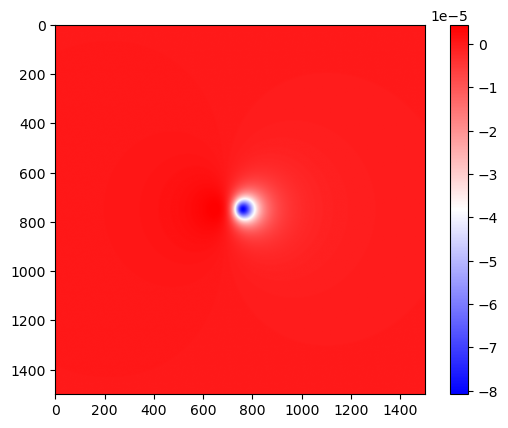

In [9]:
test_sub = generate_subsidence(size)
plt.imshow(test_sub, cmap='bwr')
plt.colorbar()

# 4. Generating Synthetic Time-Series Data

We need to create time-series data based on our simulation to train the model on. For now, the only paramater that we will change is $\Delta P$ or the pore pressure of the subsidence background.

To run a simple experiment, we can iterate over our time series for both logarthimic and linear change in the pore pressure to create varying synthetic time-series data.

First we need to get our time intervals using np.arange.

In [11]:
def get_times(total_days=1460, interval_days=49):
    # Return an array of days of step size interval_days
    return np.arange(0, total_days + 1, interval_days)

times = get_times()
times

array([   0,   49,   98,  147,  196,  245,  294,  343,  392,  441,  490,
        539,  588,  637,  686,  735,  784,  833,  882,  931,  980, 1029,
       1078, 1127, 1176, 1225, 1274, 1323, 1372, 1421])

To create an array representing the linear change in pore pressure over time, we need to first identify what our "max subsidence" is at that time. This would be the subsidence in the center of the circle. This helps us calculate the rate at which the pore pressure should change over time to find that max subsidence.

Let $S_{\text{max}}$ represent the max subsidence.

Then, $\Delta{P_{p-final}} = -S_{\text{max}} \frac{\pi D^2}{c_m (1 - \nu) V}$

Therefore the pore pressure at a discrete time $t$, $\Delta P_{p-t}$ would equal $\Delta{P_{p-final}} \frac{t}{t_{\text{final}}}$

In [12]:
def generate_linear_timeseries(times, S_max=5.0, D=50, nu=0.25, cm=1.0, V=1.0):
    delta_P_final = -S_max * ((np.pi * D**2) / (cm * (1 - nu) * V))

    time_series = [
        generate_subsidence(size, delta_P=-delta_P_final * (t / times[-1])) + generate_tropospheric_noise(size) + generate_random_noise(size)
        for t in times
    ]
    return time_series

linear_data = generate_linear_timeseries(times)

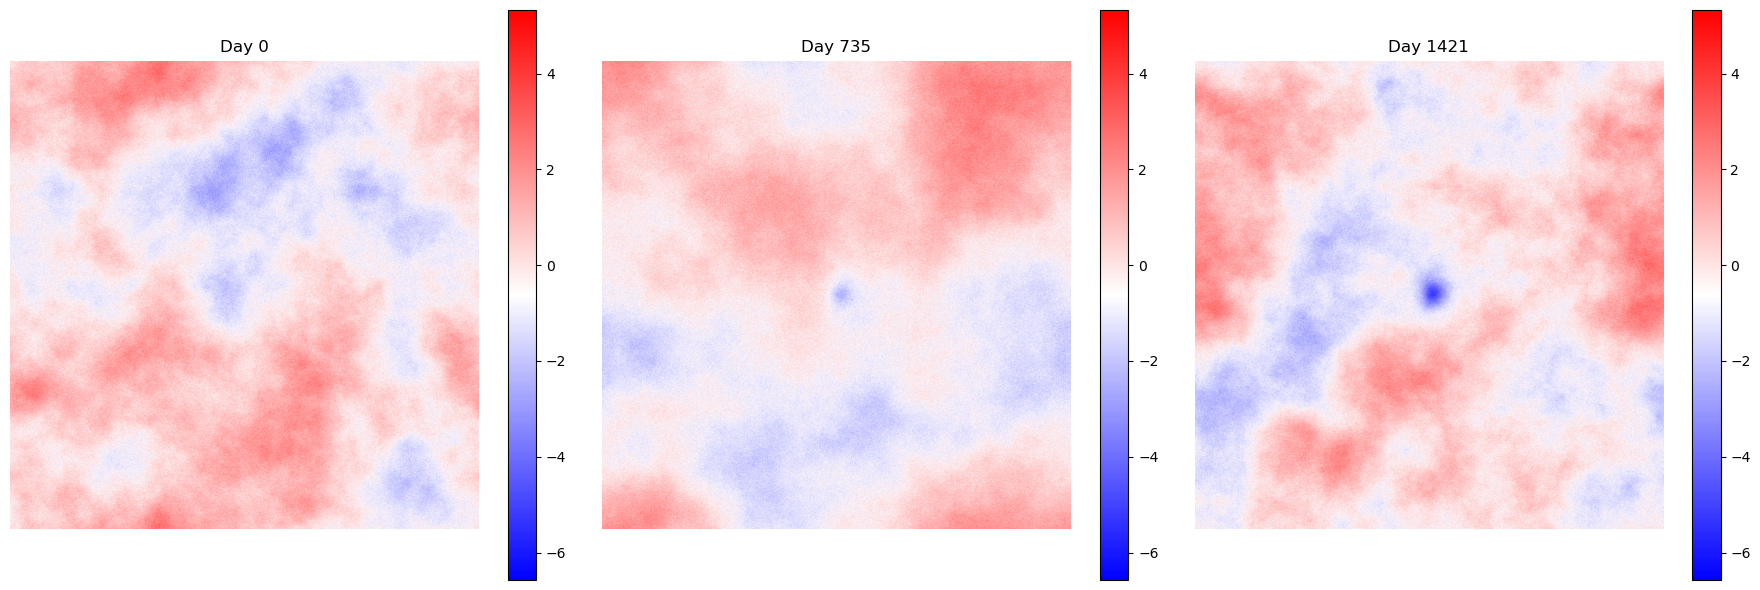

In [13]:
plot_indices = [0, len(linear_data) // 2, len(linear_data) - 1]
num_plots = len(plot_indices)

fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))

# Calculate global min and max for consistent color scale
global_min = np.min(linear_data)
global_max = np.max(linear_data)

for i, idx in enumerate(plot_indices):
    ax = axes[i] if num_plots > 1 else axes
    im = ax.imshow(linear_data[idx], cmap='bwr', vmin=global_min, vmax=global_max)
    fig.colorbar(im, ax=ax)
    ax.axis('off')
    ax.set_title(f"Day {int(times[idx])}")

plt.tight_layout()
plt.show()